# Lab 08 – Distances and PCA

**DUE: Feb 21, 2024 (Wednesday)**  

Pair Programming: Optional, but highly encouraged

Name(s): Harrison Halesworth
Class: CSCI 349 - Intro to Data Mining  
Section: 01-11am 
Semester: Spring 2024
Instructors: Brian King, Joshua Stough


# Objectives
* Practice more `pandas`
* Use chi-squared test to evaluate two categorical variables for independence
* Learn about implementing distance matrices
* Learn how to employ PCA
* A bit more with visualizations

# Partnerships
I'm encouraging you to consider working with a partner. It's not required yet, but you are strongly encouraged to do so. If the material is complex to you, talking out what you are doing with a partner can have tremendous benefits. And, if you do, both partners must be listed in the top cell above.

# Directions
Work through this lab, and enter the answers to questions that are scattered throughout this lab. It is quite likely you'll need to add additional imports as you work through the lab. Just add them to the top cell if you use them. Most expected imports are added for you already.



In [73]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist

---
**1)**	[P] Set up a pandas data frame with the following 8 observations and 3 variables.

```
   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32
A2     C       good     60
A3     B       fair     53
A4     A       poor     23
A5     B  excellent     37
A6     C       good     45
A7     B       good     49
```

Be sure to set the types of each variable as follows:
* `test1`: Nominal, levels = { "A", "B", C" }
* `test2`: Ordinal, levels = { "poor", "fair", "good", "excellent" }
* `test3`: Numeric

Use `pd.Categorical` for the nominal and ordinal variables (and pay attention to the `ordered` parameter.) Name the data frame `df`. Set the `index` correctly to match the row names in the table above.

Display the `df` data frame, and then show the output of `df.info()` to show the type of each variable in `df`.

In [74]:
# ANSWER

data = {"test1": ["A", "C", "C", "B", "A", "B", "C", "B"],
       "test2": ["excellent", "fair", "good", "fair", "poor", "excellent", "good", "good"],
       "test3": [25, 32, 60, 53, 23, 37, 45, 49]}

t1_levels = ["A", "B", "C"]
t2_levels = ["poor", "fair", "good", "excellent"]
i = ["A0", "A1", "A2", "A3", "A4", "A5", "A6", "A7"]

df = pd.DataFrame(data, index=i)

df["test1"] = pd.Categorical(df["test1"], categories=t1_levels, ordered=False)
df["test2"] = pd.Categorical(df["test2"], categories=t2_levels, ordered=True)

print(df)
df.info()

   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32
A2     C       good     60
A3     B       fair     53
A4     A       poor     23
A5     B  excellent     37
A6     C       good     45
A7     B       good     49
<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   test1   8 non-null      category
 1   test2   8 non-null      category
 2   test3   8 non-null      int64   
dtypes: category(2), int64(1)
memory usage: 480.0+ bytes


---
**2)**	[MP] Show the output of `df.describe(include='all')`. What does the `include='all'` parameter do?

In [75]:
# ANSWER

df.describe(include='all')

,test1,test2,test3
count,8,8,8.000000
unique,3,4,NaN
top,B,good,NaN
freq,3,3,NaN
mean,NaN,NaN,40.500000
std,NaN,NaN,13.416408
min,NaN,NaN,23.000000
25%,NaN,NaN,30.250000
50%,NaN,NaN,41.000000
75%,NaN,NaN,50.000000


**ANSWER:** Using include='all' as an argument makes it so that the function call prints out the 5+ number summary for all of the variables rather than just the numeric variables.

---
**3)**	[PM] Show the output of `df.test1.cat.categories`, and `df.test2.cat.categories`. What is this showing? Does it work for `df.test3.cat.categories`?

In [76]:
# ANSWER

print(df.test1.cat.categories)
print(df.test2.cat.categories)

# print(df.test3.cat.categories)

Index(['A', 'B', 'C'], dtype='object')
Index(['poor', 'fair', 'good', 'excellent'], dtype='object')


**ANSWER:** It shows the categories of the respective categorical variable that you call it on. It causes an error when you try it on the variable test3.

---
**4)**	[PM] Show the output of `df.test1.cat.codes`, and `df.test2.cat.codes`. What is this showing?

In [77]:
# ANSWER

print(df.test1.cat.codes)
print(df.test2.cat.codes)

A0    0
A1    2
A2    2
A3    1
A4    0
A5    1
A6    2
A7    1
dtype: int8
A0    3
A1    1
A2    2
A3    1
A4    0
A5    3
A6    2
A7    2
dtype: int8


**ANSWER:** Calling this shows the coded value at each index for a respective variable, for example the value for test2 at index 4 is 0, which implies that the categorical value is "poor".

---
**5)** [P] Report the counts of each level of the categorical variables.

In [78]:
# ANSWER

t1_count = df["test1"].value_counts()
t2_count = df["test2"].value_counts()
print("Value counts for test1 : \n" + str(t1_count))
print("Value counts for test2 : \n" + str(t2_count))

Value counts for test1 : 
test1
B    3
C    3
A    2
Name: count, dtype: int64
Value counts for test2 : 
test2
good         3
fair         2
excellent    2
poor         1
Name: count, dtype: int64


---
**6)** [P] Report a cross tabulation (i.e. contingency table) between `test1` and `test2`. Include the margins (i.e. the sum of the rows and the columns) in your reported table (HINT: Look up pandas `crosstab()` function).

Your results should look something like this:

```
test2  poor  fair  good  excellent  All
test1
A         1     0     0          1    2
B         0     1     1          1    3
C         0     1     2          0    3
All       1     2     3          2    8
```


In [79]:
# ANSWER

c_table = pd.crosstab(df["test1"], df["test2"], margins=True, margins_name="Total")
print(c_table)

test2  poor  fair  good  excellent  Total
test1                                    
A         1     0     0          1      2
B         0     1     1          1      3
C         0     1     2          0      3
Total     1     2     3          2      8


---
**7)** [P] From the previous table, store the contingency table without the margins in a variable called `observed`

In [80]:
# ANSWER

observed = c_table.iloc[:-1, :-1]
print(observed)

test2  poor  fair  good  excellent
test1                             
A         1     0     0          1
B         0     1     1          1
C         0     1     2          0


---
**8)** [P] Run a chi-squared test for independence using the contingency table from the previous step. Clearly report the chi2 statistic, the p value, and the degrees of freedom, and then use the p-value to clearly state whether `test1` and `test2` are independent in your Python code (no markdown).

In [112]:
# ANSWER

chi_squared, p, deg, expected_values = stats.chi2_contingency(c_table)

print("Chi-squared statistic:", chi_squared)
print("P value:", p)
print("Degrees of freedom:", deg)

if p < 0.05:
    print("test1 and test2 are not independent because" + 
    " the p value is less than .05.")
else:
    print("test1 and test2 are independent because" +
    " the p value is greater than .05.")

Chi-squared statistic: 6.444444444444445
P value: 0.8920432250963304
Degrees of freedom: 12
test1 and test2 are independent because the p value is greater than .05.


---
Now, you're going to explore some similarities between observations. Yes, this is a SMALL dataset! (Don't bother to explore large data until you can understand how they work on small, toy experimental data!)

Before you can compute a pairwise distance matrix to report the distance between all pairs of observations, always remember that **you can only compute distances between strictly numeric data.** Therefore, you must convert your data to numeric types for ALL variables you want to include in your distance metric.

---
**9)** Create a new data frame called `df_num` that represents a numeric version of the above. Do NOT do any rescaling of your variables yet!

NOTE: If you do this from a dataframe that has the categorical variables set up properly, then this step is simple to do. The two choices I generally follow are either:

   1. use the cat member of your categorical data, which stores a `CategoricalAccessor` object (look it up), or
   2. use one of the encoders in the `sklearn.preprocessing` module.

The first option is easier, and yet another reason why it's so important to take the time to preprocess your data as correctly and error-free as possible.

If you do it correctly, your resulting dataframe should look something like this:
```
    test1  test2  test3
A0      0      3     25
A1      2      1     32
A2      2      2     60
A3      1      1     53
A4      0      0     23
A5      1      3     37
A6      2      2     45
A7      1      2     49
```

In [82]:
# ANSWER

df_num = df.copy(deep=True)
df_num["test1"] = df_num["test1"].cat.codes
df_num["test2"] = df_num["test2"].cat.codes
print(df_num)

    test1  test2  test3
A0      0      3     25
A1      2      1     32
A2      2      2     60
A3      1      1     53
A4      0      0     23
A5      1      3     37
A6      2      2     45
A7      1      2     49


---
**10)** [P] As you learned in lecture, you absolutely must rescale your data to fall on a similar scale for most methods to be meaningful. There are different approaches to doing so. A standardized zscore is among the most common, but not necessarily always the best approach, especially when you are dealing with numeric representations of true categorical data. Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have categorical data.

Let's first try to rescale our data to all fall between the values of 0 and 1. Use the `MinMaxScaler` in `sklearn.preprocessing` to rescale all variables to fall between 0 and 1. Store the transformed data as a pandas data frame called `df_num_zeroone`. Your result should look as follows:

```
    test1     test2     test3
A0    0.0  1.000000  0.054054
A1    1.0  0.333333  0.243243
A2    1.0  0.666667  1.000000
A3    0.5  0.333333  0.810811
A4    0.0  0.000000  0.000000
A5    0.5  1.000000  0.378378
A6    1.0  0.666667  0.594595
A7    0.5  0.666667  0.702703
```



In [83]:
# ANSWER

s = MinMaxScaler()
tmp = s.fit_transform(df_num)
df_num_zeroone = pd.DataFrame(tmp, columns=df_num.columns, index=df.index)
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.054054
A1,1.0,0.333333,0.243243
A2,1.0,0.666667,1.000000
A3,0.5,0.333333,0.810811
A4,0.0,0.000000,0.000000
A5,0.5,1.000000,0.378378
A6,1.0,0.666667,0.594595
A7,0.5,0.666667,0.702703


---
**11)**	Notice the value of `test3`. It's OK, but there are times we have solid knowledge of what we expect our range to be. We can (and usually should) rescale our data using that knowledge. In the case of `test3`, suppose that you learned that the data must fall between 0 and 100.

Reassign `test3` so that the min and max before rescaling are assuming to be between 0 and 100, respectively. (i.e. simply divide the original variable by 100!)

In [84]:
# ANSWER

df_num["test3"] = df_num["test3"] / 100
df_num_zeroone["test3"] = df_num["test3"]
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.25
A1,1.0,0.333333,0.32
A2,1.0,0.666667,0.60
A3,0.5,0.333333,0.53
A4,0.0,0.000000,0.23
A5,0.5,1.000000,0.37
A6,1.0,0.666667,0.45
A7,0.5,0.666667,0.49


---
**12)**	[P] Compute a single distance matrix called `distmat_zeroone`. Use a standard Euclidean distance measure. Your reported result should be an 8x8 matrix with appropriately labeled rows and columns. (HINT – study the output of the distance matrix functions. They do not output a square matrix. As discussed in lecture you can use either `pairwise_distances` from scikit-learn, or the `pdist` and `squareform` functions in `scipy.spatial.distance`). Be sure to label the rows and columns to be the index from the input dataframe. Round it to 3 significant digits.

Your result should look something like this...
```
       A0     A1     A2     A3     A4     A5     A6     A7
A0  0.000  1.204  1.111  0.879  1.000  0.514  1.073  0.647
A1  1.204  0.000  0.435  0.542  1.058  0.835  0.358  0.625
A2  1.111  0.435  0.000  0.605  1.258  0.643  0.150  0.512
A3  0.879  0.542  0.605  0.000  0.672  0.686  0.606  0.336
A4  1.000  1.058  1.258  0.672  0.000  1.127  1.222  0.873
A5  0.514  0.835  0.643  0.686  1.127  0.000  0.606  0.354
A6  1.073  0.358  0.150  0.606  1.222  0.606  0.000  0.502
A7  0.647  0.625  0.512  0.336  0.873  0.354  0.502  0.000
```

In [113]:
# ANSWER

distmat_zeroone = pairwise_distances(df_num_zeroone, 
                                     metric='euclidean')
distmat_zeroone = np.round(distmat_zeroone, 3)
distmat_zeroone = pd.DataFrame(distmat_zeroone, 
                               index=df_num_zeroone.index, 
                               columns=df_num_zeroone.index)

print(distmat_zeroone)

       A0     A1     A2     A3     A4     A5     A6     A7
A0  0.000  1.204  1.111  0.879  1.000  0.514  1.073  0.647
A1  1.204  0.000  0.435  0.542  1.058  0.835  0.358  0.625
A2  1.111  0.435  0.000  0.605  1.258  0.643  0.150  0.512
A3  0.879  0.542  0.605  0.000  0.672  0.686  0.606  0.336
A4  1.000  1.058  1.258  0.672  0.000  1.127  1.222  0.873
A5  0.514  0.835  0.643  0.686  1.127  0.000  0.606  0.354
A6  1.073  0.358  0.150  0.606  1.222  0.606  0.000  0.502
A7  0.647  0.625  0.512  0.336  0.873  0.354  0.502  0.000


---
**13)**	[P] Output the top three closest (i.e. most similar) pairs of observations. You MUST write Python code to report these results! Do not simply print out your distance matrix and tell me your answers! Consider that this may have been thousands of observations! Always generate reported answers in code!

For each pair, output the pair of observations from the original dataframe and the distance between them.

(HINT: I actaully found this easiest to do with the output of `pdist` with the `sorted` function.)

Your first closest pair output might have output that looks something like this:

```
Closest: # 0 : ['A2', 'A6'] dist=0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45
```


In [115]:
# ANSWER:

d = np.round(pdist(df_num_zeroone),3)
closest = sorted(d)

for distance in closest[:3]:
    x, y = np.where(distmat_zeroone.eq(distance))[0]
    print(f"Pair: [{distmat_zeroone.index[x]}, {distmat_zeroone.index[y]}] dist={distance}")

Pair: [A2, A6] dist=0.15
Pair: [A3, A7] dist=0.336
Pair: [A5, A7] dist=0.354


---
**14)**	[P] Output the three observations that are *least similar*, with the two most distant observations output first. Again, for each pair, output the two observations, and the distance between them

In [119]:
# ANSWER

d = np.round(pdist(df_num_zeroone),3)
farthest = sorted(d, reverse=True)

for distance in farthest[:3]:
    x, y = np.where(distmat_zeroone.eq(distance))[0]
    print(
    f"Pair: [{distmat_zeroone.index[x]}, {distmat_zeroone.index[y]}] dist={distance}"
    )

Pair: [A2, A4] dist=1.258
Pair: [A4, A6] dist=1.222
Pair: [A0, A1] dist=1.204


---
**15)**	[P] Create a new data frame, `df_num_binarized`, that stores a *binarized* version for `test1` and `test2`. The variable `test3` is already numeric, scaled to fall between 0 and 1 already. So, once you've created `df_num_binarized`, then copy the variable `test3` from `df_num_zeroone` to `df_num_binarized`.

(HINT: Remember, `pd.get_dummies` makes this quite easy to do, or you could use `OneHotEncoder` from `sklearn.preprocessing` and set `sparse=False, dtype=int`)

Your first row might look something like the following:
```
    test1_A  test1_B  test1_C  test2_poor  test2_fair  test2_good  test2_excellent  test3
A0        1        0        0           0           0           0                1   0.25
```


In [88]:
# ANSWER

df_num_binarized = pd.get_dummies(df, dtype=int)
df_num_binarized = df_num_binarized.drop(df_num_binarized.columns[0], axis=1)
df_num_binarized["test3"] = df_num_zeroone["test3"]
df_num_binarized

,test1_A,test1_B,test1_C,test2_poor,test2_fair,test2_good,test2_excellent,test3
A0,1,0,0,0,0,0,1,0.25
A1,0,0,1,0,1,0,0,0.32
A2,0,0,1,0,0,1,0,0.60
A3,0,1,0,0,1,0,0,0.53
A4,1,0,0,1,0,0,0,0.23
A5,0,1,0,0,0,0,1,0.37
A6,0,0,1,0,0,1,0,0.45
A7,0,1,0,0,0,1,0,0.49


---
**16)**	[P] Now, compute `distmat_binarized` by computing the distance matrix for the df_binarized.

In [116]:
# ANSWER

distmat_binarized = pairwise_distances(df_num_binarized, metric='euclidean')
distmat_binarized = np.round(distmat_binarized, 3)
distmat_binarized = pd.DataFrame(distmat_binarized, 
                                 index=df_num_binarized.index, 
                                 columns=df_num_binarized.index)

print(distmat_binarized)

       A0     A1     A2     A3     A4     A5     A6     A7
A0  0.000  2.001  2.030  2.020  1.414  1.419  2.010  2.014
A1  2.001  0.000  1.442  1.430  2.002  2.001  1.420  2.007
A2  2.030  1.442  0.000  2.001  2.034  2.013  0.150  1.418
A3  2.020  1.430  2.001  0.000  2.022  1.423  2.002  1.415
A4  1.414  2.002  2.034  2.022  0.000  2.005  2.012  2.017
A5  1.419  2.001  2.013  1.423  2.005  0.000  2.002  1.419
A6  2.010  1.420  0.150  2.002  2.012  2.002  0.000  1.415
A7  2.014  2.007  1.418  1.415  2.017  1.419  1.415  0.000


---
**17)**	[P] Report the three closest pairs, and the three most distant pairs from distmat_binarized

In [120]:
# ANSWER

d_bin = np.round(pdist(df_num_binarized),3)
closest_bin = sorted(d_bin)
np.where(distmat_binarized.eq(1.415))
for distance in closest_bin[:3]:
    count = 0
    if len(np.where(distmat_binarized.eq(distance))[0]) == 2:
        x, y = np.where(distmat_binarized.eq(distance))[0]
        print(
        f"Pair: [{distmat_binarized.index[x]}, {distmat_binarized.index[y]}] dist={distance}"
        )
        count += 1
    else:
        x1, y1, x2, y2 = np.where(distmat_binarized.eq(distance))[0]
        print(
        f"Pair: [{distmat_binarized.index[x1]}, {distmat_binarized.index[y1]}] dist={distance}"
        )

Pair: [A2, A6] dist=0.15
Pair: [A0, A4] dist=1.414
Pair: [A3, A6] dist=1.415


---
**18)**	[M] Take a moment and compare and contrast your results. Which method do you think have the better results? Why? Which variable do you think was the distinguishing player in affecting the different outcomes between both of the above approaches to transforming your data to numeric results? Summarize what would have been the best transformation to make for all three variables.

**ANSWER:** Because test3 is the same in both cases, we must only consider the values generated for test1 and test2, so we can definitely say that test3 was not the distinguishing factor. I believe that test2 was the distinguishing factor because it's categorical values are ordinal and there are also more than there are for test1. Both had A2 and A6 as the closest which makes sense.

In [91]:
df

# Pair: [A2, A6] dist=0.15
# Pair: [A3, A7] dist=0.336
# Pair: [A5, A7] dist=0.354

# Pair: [A2, A6] dist=0.15
# Pair: [A0, A4] dist=1.414
# Pair: [A3, A6] dist=1.415

,test1,test2,test3
A0,A,excellent,25
A1,C,fair,32
A2,C,good,60
A3,B,fair,53
A4,A,poor,23
A5,B,excellent,37
A6,C,good,45
A7,B,good,49


---
**19)**	[P] Load in your next dataset using the following:

`df_car_crashes = sns.load_dataset('car_crashes')`

The dataset is directly downloaded from:
[https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv](https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv)

So, your first step with any new dataset is to understand your data. What are the variables? What does each observation represent? Sometimes, it's easy to figure out. Just Google! And, sometimes we need to make the best guess regarding our variables. For now, don't worry too much about specifics. This is a very simplified, highly aggregated dataset from much more extensive stats drawn from the [Insurance Institute for Highway Safety](https://www.iihs.org/iihs/topics/t/general-statistics/fatalityfacts/state-by-state-overview) (NOTE - this might make a great repository for some project?)

In [92]:
# ANSWER

df_car_crashes = sns.load_dataset('car_crashes')
df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
4,12.0,4.200,3.360,10.920,10.680,878.41,165.63,CA


---
**20)**	[P] Preprocess your data. Minimally, you should move the state code to become the index for the dataframe, and then drop that column from your dataframe.

In [93]:
# ANSWER

df_car_crashes.set_index(df_car_crashes["abbrev"], inplace=True)
df_car_crashes.index.name = "State"
df_car_crashes.drop(df_car_crashes.columns[-1], axis=1, inplace=True)
df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
State,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


---
**21)**	[P] Create a new dataframe called `df_car_crashes_zscore` that represents the zscore transformation for `df_car_crashes`. Again, show the first five rows.



In [94]:
# ANSWER

df_car_crashes_zscore = df_car_crashes.apply(zscore)
df_car_crashes_zscore.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
State,,,,,,,
AL,0.737446,1.168148,0.439938,1.002301,0.277692,-0.580083,0.430514
AK,0.565936,1.212695,-0.211311,0.608532,0.807258,0.943258,-0.022900
AZ,0.688443,0.756709,0.187615,0.459357,1.033141,0.070876,-0.981778
AR,1.619498,-0.483614,0.547408,1.676052,1.951700,-0.337701,0.321125
CA,-0.928653,-0.399524,-0.891763,-0.594276,-0.891968,-0.048418,1.266178


---
**22)**	[P] Create a distance matrix called `distmat_cars` based on the `df_car_crashes_zscore`. Display the entire distance matrix (which will likely be simplified visually due to its size)

In [123]:
# ANSWER

distmat_cars = pairwise_distances(df_car_crashes_zscore, metric='euclidean')
distmat_cars = np.round(distmat_cars, 3)
distmat_cars = pd.DataFrame(distmat_cars, 
                            index=df_car_crashes_zscore.index, 
                            columns=df_car_crashes_zscore.index)

print(distmat_cars)

State     AL     AK     AZ     AR     CA     CO     CT     DE     DC     FL  \
State                                                                         
AL     0.000  1.849  1.876  2.616  3.450  2.687  4.023  2.427  6.627  2.863   
AK     1.849  0.000  1.461  2.962  3.504  2.675  3.720  1.305  5.923  2.014   
AZ     1.876  1.461  0.000  2.593  3.873  2.691  4.341  2.323  6.312  2.472   
AR     2.616  2.962  2.593  0.000  4.774  4.082  5.512  3.376  7.648  2.723   
CA     3.450  3.504  3.873  4.774  0.000  1.382  1.360  2.801  3.725  3.294   
CO     2.687  2.675  2.691  4.082  1.382  0.000  2.171  2.349  4.294  2.885   
CT     4.023  3.720  4.341  5.512  1.360  2.171  0.000  2.793  3.101  3.490   
DE     2.427  1.305  2.323  3.376  2.801  2.349  2.793  0.000  5.107  1.443   
DC     6.627  5.923  6.312  7.648  3.725  4.294  3.101  5.107  0.000  5.343   
FL     2.863  2.014  2.472  2.723  3.294  2.885  3.490  1.443  5.343  0.000   
GA     2.740  2.609  2.619  3.132  1.995  1.593  2.8

---
**23)**	[P] An interesting way to suggest outliers is to take a distance matrix, aggregate the mean over each row or column, then sort the output in order. Why would this work? Because an observation that is an outlier should have a relatively high mean distance to all other observations! Do this, and output the list in descending order. (HINT: DC should be your largest outlier, listed first.)

In [96]:
# ANSWER

mean_dist = distmat_cars.mean(axis=1)
sorted_dist = mean_dist.sort_values(ascending=False)

print(sorted_dist)

State
DC    5.265667
ND    5.257275
SC    5.214314
LA    4.767431
MT    4.759843
WV    4.512765
NJ    4.310804
MA    4.197490
MS    4.048392
AR    3.897667
MD    3.749941
MN    3.719706
OK    3.618059
HI    3.591784
SD    3.585235
TX    3.572118
NY    3.531824
CT    3.514098
WI    3.468765
ID    3.440843
PA    3.440608
UT    3.438176
RI    3.434078
WA    3.297020
FL    3.205451
VA    3.156373
OR    3.130471
CA    3.116882
ME    3.105235
NH    3.100922
IA    3.098451
AK    3.091294
MI    3.072784
NE    3.065176
AL    3.033314
DE    3.022000
AZ    2.999824
TN    2.965333
KY    2.964392
NM    2.914961
IN    2.841431
WY    2.839451
VT    2.820118
NC    2.777647
OH    2.746804
MO    2.734431
GA    2.726569
NV    2.627529
CO    2.617373
IL    2.602275
KS    2.573686
dtype: float64


----
**24)**	[M] From this analysis, which 3 states seem to be the outliers?

**ANSWER:** The three states that seem to be outliers are DC, ND, and SC.

---
**25)**	[P] OK. Let's explore the data visually. First, using the original, unscaled data frame `df_car_crashes`, create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size of the point. Create a label near to every point representing the two letter state code.

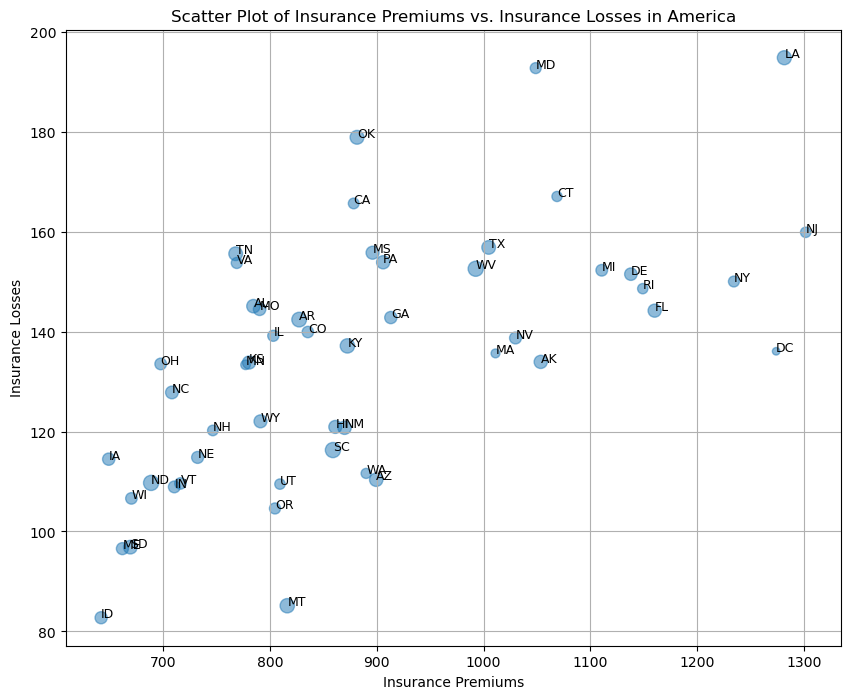

In [97]:
# ANSWER

premiums = df_car_crashes["ins_premium"]
losses = df_car_crashes["ins_losses"]
total = df_car_crashes["total"]
index = df_car_crashes.index

plt.figure(figsize=(10, 8))
plt.scatter(premiums, losses, s=total*5, alpha=0.5)

# States
for i, state in enumerate(index):
    plt.text(premiums.iloc[i], losses.iloc[i], state, fontsize=9)

plt.xlabel("Insurance Premiums")
plt.ylabel("Insurance Losses")
plt.title("Scatter Plot of Insurance Premiums vs. Insurance Losses in America")

plt.grid(True)
plt.show()

---
**26)** [P] Next, generate **two** plots that show some relationships between variables in the data. Try to use as many variables as you can without creating chaos! Don't just throw in multiple variables for the sake of showing them, only include them if it makes sense to do so. **Your aim is to derive meaning from your data. Good visualizations tell a story.** Strive to use at additional variables as size, as color, or even shape in your data so you can show more than just 2 variables on a single plot. Add titles, legends and label your axes as appropriate.

After each plot, create a markdown cell and briefly draw conclusions from your plot.

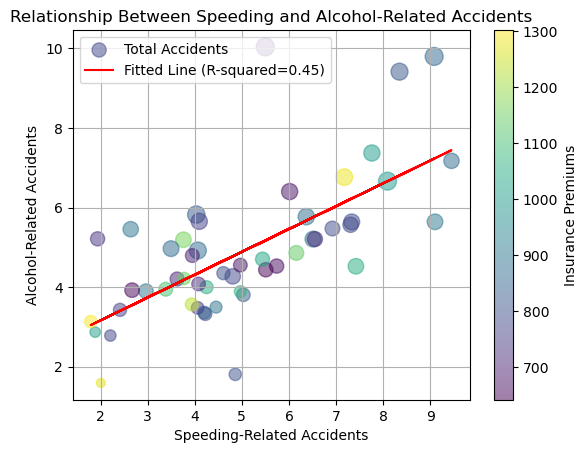

In [98]:
# ANSWER
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.scatter(df_car_crashes["speeding"], 
            df_car_crashes["alcohol"], 
            s=df_car_crashes["total"]*7, 
            c=df_car_crashes["ins_premium"], 
            cmap="viridis", 
            alpha=0.5, 
            label="Total Accidents")

X = df_car_crashes["speeding"].values.reshape(-1, 1)
y = df_car_crashes["alcohol"].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)


r_squared = r2_score(y, y_pred)

plt.plot(df_car_crashes["speeding"], 
         y_pred, color="red", 
         label=f'Fitted Line (R-squared={r_squared:.2f})')
plt.title("Relationship Between Speeding and Alcohol-Related Accidents")
plt.xlabel("Speeding-Related Accidents")
plt.ylabel("Alcohol-Related Accidents")
cbar = plt.colorbar()
cbar.set_label("Insurance Premiums")

plt.legend()
plt.grid(True)
plt.show()

**ANSWER:**

This graph plots the relationship between speeding and alcohol related accidents along with the insurance premium for each as the color code. I then plotted a linear regression line with an $R^{2}$ value of 0.45, which does not indicate a clear correlation between alcohol related accidents and speeding accidents

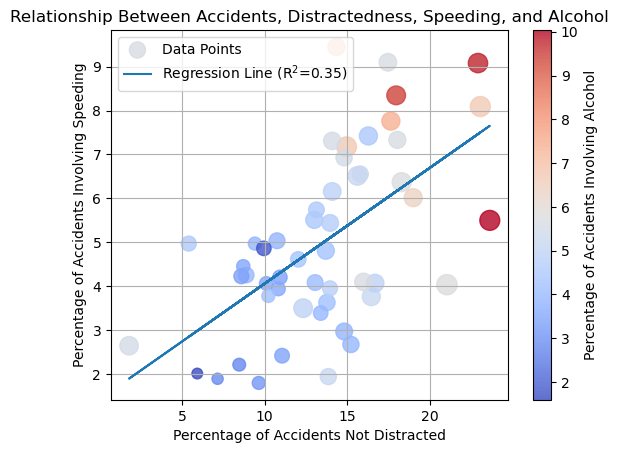

In [99]:
# ANSWER:

x_values = df_car_crashes["not_distracted"] 
y_values = df_car_crashes["speeding"]
color_values = df_car_crashes["alcohol"]
size_values = df_car_crashes["no_previous"] 

plt.scatter(x_values, 
            y_values, 
            c=color_values, 
            cmap='coolwarm', 
            s=size_values*10, 
            alpha=0.8, 
            label='Data Points')
plt.colorbar(label='Percentage of Accidents Involving Alcohol')

z = np.polyfit(x_values, y_values, 1)
p = np.poly1d(z)
plt.plot(x_values,
         p(x_values), 
         label=f'Regression Line (R$^2$={np.round(np.corrcoef(x_values, y_values)[0,1]**2, 2)})')

plt.xlabel("Percentage of Accidents Not Distracted")
plt.ylabel("Percentage of Accidents Involving Speeding")
plt.title("Relationship Between Accidents, Distractedness, Speeding, and Alcohol")
plt.legend()
plt.grid(True)
plt.show()

**ANSWER:** For this plot I plotted the percentage of accidents that weren't distracted vs the percentage of accidents involving speeding with percentage of accidents involving alcohol, along with a regression line with an $R^2$ value of 0.35, which does not indicate a clear correlation between speeding and not distracted, which surprised me. What didn't surprise me was the fact that the data points toward the upper right of the graph are more red, which indicates a higher percentage of alcohol related accidents, not distracted and speeding.

**27)**	 [P] Now, we're going to look at the data visually, but use a PCA transformation to help give a better sense of trends and differences among our data.

Run a full PCA on the zscore transformed data. Set `n_components` to be the number of variables in the original data. Be sure to fit the data to your PCA model, and then output the components, explained variance, and the explained variance ratio.

In [100]:
# ANSWER

pca = PCA(n_components=df_car_crashes.shape[1])
pca.fit(df_car_crashes_zscore)

print("Principal Components:\n", pca.components_)
print("\nExplained Variance:\n", pca.explained_variance_)
print("\nExplained Variance Ratio:\n", pca.explained_variance_ratio_)

Principal Components:
 [[ 0.47947078  0.37534719  0.45437635  0.4380328   0.45703414 -0.1308319
  -0.06996048]
 [ 0.06893769  0.0765846   0.03345835  0.04237473  0.0961294   0.6852266
   0.71252436]
 [-0.26908802  0.81826935  0.08293253 -0.12616845 -0.31798812  0.25614247
  -0.26173503]
 [ 0.0389558  -0.36374887  0.14834351  0.1712655   0.03948141  0.65639617
  -0.61839859]
 [ 0.14597659 -0.02282818  0.35479821 -0.85646854  0.33611019  0.04214531
  -0.06327152]
 [-0.16970508 -0.22479246  0.7837677   0.08510479 -0.50401185 -0.11577348
   0.17805184]
 [ 0.80082487  0.01784783 -0.15285774 -0.14247844 -0.55875371  0.04126619
  -0.02804966]]

Explained Variance:
 [4.0942308  1.6095732  0.56161403 0.35753958 0.2863854  0.20263316
 0.02802383]

Explained Variance Ratio:
 [0.57342168 0.22543042 0.07865743 0.05007557 0.04011    0.02837999
 0.00392491]


---
**28)**	[M] Use your intuition – what do the weights of the first couple of PCs suggest explains most of the variance in the data? Are there certain variables that seem to be more significant? Or are they all playing a role?

**ANSWER:** It seems from the PCs that most of the variables do contribute some to the variance but it is clear that the total variable contributes to a majority of it as its explained variance ratio is nearly 60%. I think I can confidently say that all except the ins_losses variable contribute to the variance as ins_losses only has an explained variance ratio of less than half of a %.

In [101]:
df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
State,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


---
**29)** [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90% of the explained variance?

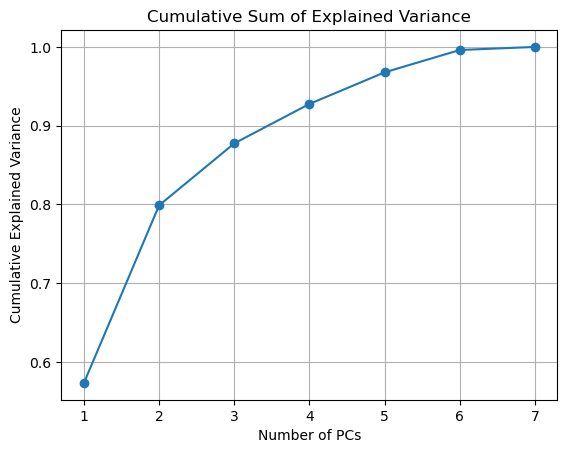

4 components will get you to 90% of the explained variance.


In [102]:
# ANSWER

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_variance) + 1), 
         cumulative_variance, 
         marker="o", 
         linestyle="-")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Sum of Explained Variance")
plt.grid(True)
plt.show()
print("4 components will get you to 90% of the explained variance.")

---
**30)**	[P] Transform the z_score transformed data using your PCA model (HINT: use the `transform` function of the pca object.)

(NOTE: I often just store the transformed data temporarily as some arbitrary variable, X, to make it easier to manipulate the data for plotting and also use later.)

In [103]:
# ANSWER

X = pca.transform(df_car_crashes_zscore)
X[:5]

array([[ 1.60367129,  0.13344927,  0.31788093, -0.79529296, -0.57971878,
         0.04622256,  0.21018495],
       [ 1.14421188,  0.85823399,  0.73662642,  0.31898763, -0.22870123,
        -1.00262531,  0.00896585],
       [ 1.43217197, -0.42050562,  0.3381364 ,  0.55251314,  0.16871805,
        -0.80452278, -0.07610742],
       [ 2.49158352,  0.34896812, -1.78874742,  0.26406388, -0.37238226,
        -0.48184939, -0.14763646],
       [-1.75063825,  0.63362517, -0.1361758 , -0.97491605, -0.31581147,
         0.17850962, -0.06895829]])

---
**31)**	[P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label each point, and label your axes as component 1 and component 2, respectively.

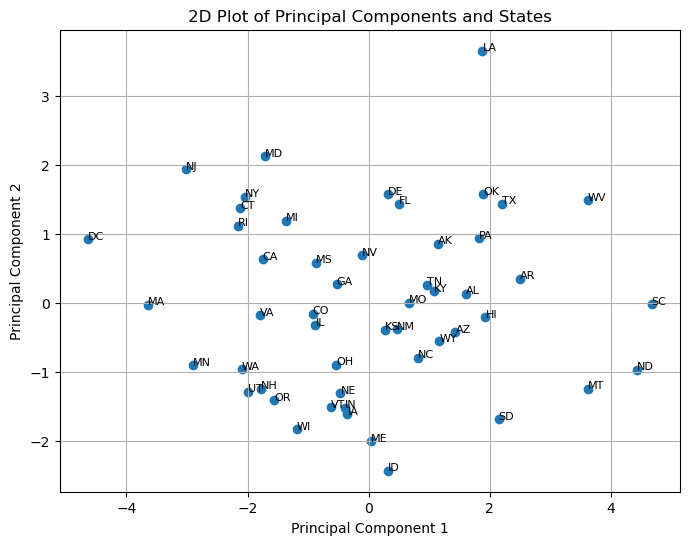

In [104]:
# ANSWER

PC1 = X[:, 0]
PC2 = X[:, 1]
plt.figure(figsize=(8, 6))
plt.scatter(PC1, PC2)

# States
for i, state in enumerate(df_car_crashes_zscore.index):
    plt.text(PC1[i], PC2[i], state, fontsize=8)


plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D Plot of Principal Components and States")
plt.grid(True)
plt.show()

---
**32)**	[M] Compare the states you reported as potential outliers above to those that appear to be outliers from your plot. Do the same results seem to hold?

**ANSWER:** I previously noted that DC, ND, SC were outliers, and it still seems that they are extremes but other states like LA seem to be even further according to these principal components.

---
**33)**	[P] Read how to generate a 3D scatterplot, and use it to generate a scatterplot of the first 3 components.

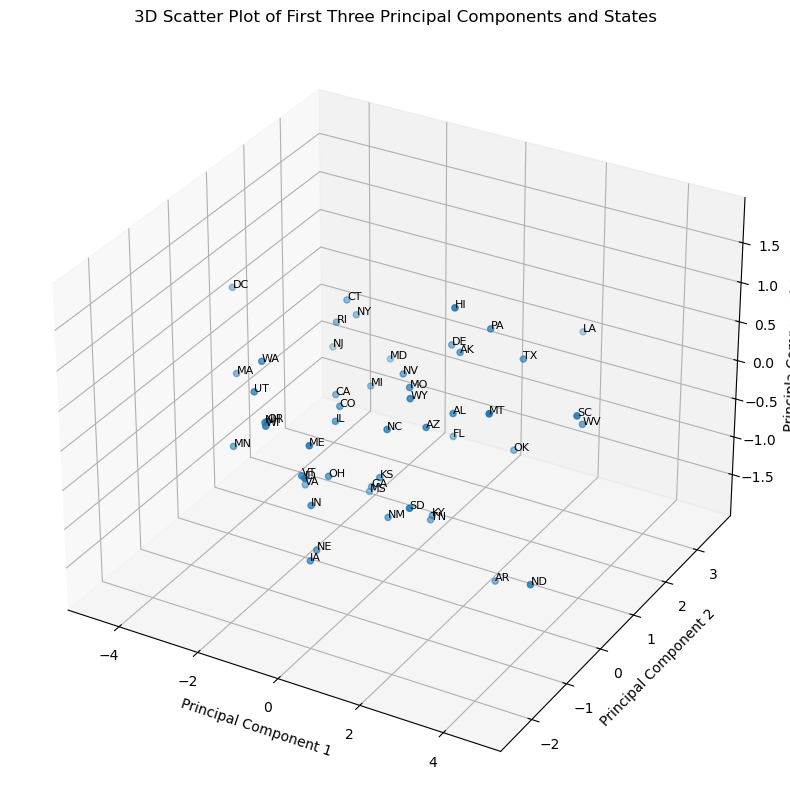

In [107]:
# ANSWER
from mpl_toolkits.mplot3d import Axes3D

PC1 = X[:, 0]
PC2 = X[:, 1]
PC3 = X[:, 2]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PC1, PC2, PC3)

# States
for i, state in enumerate(df_car_crashes_zscore.index):
    ax.text(PC1[i], PC2[i], PC3[i], state, fontsize=8)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principla Component 3")
ax.set_title("3D Scatter Plot of First Three Principal Components and States")
plt.show()

---
**34)**	[M] Do the same outliers still stand out?

**ANSWER:** DC and ND seem to still be extremes but SC is very close to WV and LA still seems to be a considerable outlier as well. Overall though, they don't seem to be as egregious as you would think by just looking at the original mean distances.